## データセットのダウンロード


In [ ]:
import kagglehub

# Download latest versions
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)


/home/kosukeyano/workspace/huber_aime/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/kosukeyano/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [ ]:
import os
import tarfile
from pathlib import Path

# ダウンロードされたデータセットのパス
print("Path to dataset files:", path)


Path to dataset files: /home/kosukeyano/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3


In [ ]:
import logging
import os
import random
import time
from copy import deepcopy
from pathlib import Path
from typing import Dict

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as tfms
import torchvision.transforms.functional as T
from albumentations.pytorch import ToTensorV2
from PIL import Image
from prettytable import PrettyTable
from sklearn.metrics import roc_auc_score
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.models import densenet121
from tqdm.auto import tqdm


def set_seed_everything(seed: int, deterministic: bool = True):
    """全ライブラリの乱数を固定"""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def seed_worker(worker_id: int):
    """DataLoader worker 用のシード初期化。"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


# DataLoader / random_split で共有する乱数生成器
TORCH_GENERATOR = torch.Generator()


In [ ]:
class CFG:
    CLASS_NAMES = [
        "Atelectasis",
        "Cardiomegaly",
        "Effusion",
        "Infiltration",
        "Mass",
        "Nodule",
        "Pneumonia",
        "Pneumothorax",
        "Consolidation",
        "Edema",
        "Emphysema",
        "Fibrosis",
        "Pleural_Thickening",
        "Hernia",
    ]

    # 元の固定PATH（比較用）
    # BASE_PATH = Path(
    #     "/home/kosukeyano/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3"
    # )
    BASE_PATH = (
        Path(path)
        if "path" in globals()
        else Path(
            "/home/kosukeyano/.cache/kagglehub/datasets/nih-chest-xrays/data/versions/3"
        )
    )
    # 画像ルート（展開後にimages/配下にjpgが並ぶ想定）
    # IMAGE_ROOT = BASE_PATH / "images"
    # 修正：images_001〜images_012 を包含（クラス本体内の内包表記スコープ問題を避けるためforで構築）
    IMAGE_DIRS = []
    for i in range(1, 13):
        IMAGE_DIRS.append(BASE_PATH / f"images_{i:03d}" / "images")
    BEST_MODEL_PATH = (
        "/home/kosukeyano/workspace/huber_aime/notebook/models/best_model.pt"
    )
    EPOCHS = 20
    DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    INTERVAL = 10
    # 追加：再現性
    SEED = 42


In [ ]:
# 乱数の固定を適用
set_seed_everything(CFG.SEED, deterministic=True)
# random_split / DataLoader で用いる Generator にもシードを設定
TORCH_GENERATOR.manual_seed(CFG.SEED)


In [ ]:
CFG.DEVICE


device(type='cuda')

In [ ]:
# 元のサンプル用（比較用）
# df = pd.read_csv(CFG.BASE_PATH / "sample_labels.csv")
# 修正：フルデータセットのラベルCSV
# NIH公式配布のメタデータは Data_Entry_2017.csv（カラム: Image Index, Finding Labels, ...）
labels_csv = CFG.BASE_PATH / "Data_Entry_2017.csv"
assert labels_csv.exists(), f"ラベルCSVが見つかりません: {labels_csv}"
df = pd.read_csv(labels_csv)


In [ ]:
df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
# 元のコード（比較用）
# df = df[["Image Index", "Finding Labels"]]
# 修正：列選択は.locで行い、後続で編集するのでcopy()で独立させる
df = df.loc[:, ["Image Index", "Finding Labels"]].copy()


In [ ]:
df


,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [ ]:
# Make paths absolute
# 元のコード（比較用）
# df["Image Index"] = [
#     CFG.BASE_PATH / f"images/{path}" for path in df["Image Index"].values
# ]
# Remove "No Finding"
# 元のコード（比較用）
# df = df[df["Finding Labels"].isin(["No Finding"]) == False]

# 修正：複数ディレクトリ(images_001..images_012)を走査して最初に見つかったパスを採用
from pathlib import Path as _PathAlias


def _resolve_image_path(file_name: str):
    for root in CFG.IMAGE_DIRS:
        candidate = root / file_name
        if candidate.exists():
            return candidate
    return None


resolved_paths = [_resolve_image_path(fn) for fn in df["Image Index"].values]
missing_mask = [p is None for p in resolved_paths]
num_missing = sum(missing_mask)
print(f"Missing images (not found in images_001..012): {num_missing}")

# 欠損がある行を落とす（安全策）
if num_missing > 0:
    df = df.loc[[not m for m in missing_mask]].copy()
    resolved_paths = [p for p in resolved_paths if p is not None]

# 列代入は.locで明示
df.loc[:, "Image Index"] = resolved_paths

# 修正：ブールインデックス後はcopy()で独立
mask = ~df["Finding Labels"].isin(["No Finding"])
df = df.loc[mask].copy()


Missing images (not found in images_001..012): 0


In [ ]:
df.head(10)


,Image Index,Finding Labels
0,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly
1,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly|Emphysema
2,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly|Effusion
4,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia
5,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia
6,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia
7,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia|Infiltration
8,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia
9,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia
10,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia


In [ ]:
labels = np.zeros(shape=(len(df), 14))
for idx, lab in tqdm(enumerate(df["Finding Labels"].values), total=len(df)):
    lbls = lab.split("|")
    lbl_arr = np.zeros(len(CFG.CLASS_NAMES))
    for l in lbls:
        lbl_arr[CFG.CLASS_NAMES.index(l)] = 1
    labels[idx] = lbl_arr


100%|██████████| 51759/51759 [00:00<00:00, 623226.88it/s]


In [ ]:
labels


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(51759, 14))

In [ ]:
d = {k: v for k, v in zip(CFG.CLASS_NAMES, labels.transpose())}


In [ ]:
# 元のコード（比較用）
# for k, v in d.items():
#     df[k] = v

# 修正案1：列名リストを作り、一括代入（最も高速で明確）
cols = list(d.keys())
values = np.column_stack([d[k] for k in cols])
df.loc[:, cols] = values


In [ ]:
df.head()


,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly|Emphysema,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly|Effusion,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.to_csv("/home/kosukeyano/workspace/huber_aime/data/final.csv", index=False)


In [ ]:
def plot_images(df, rows, columns, figsize=(20, 20)):
    """
    Function to plot images
    """
    fig, axs = plt.subplots(rows, columns, figsize=figsize)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    idx = 1
    for i in range(rows):
        for j in range(columns):
            image = np.asarray(Image.open(df["Image Index"].values[idx]).convert("RGB"))
            labels = df["Finding Labels"].values[idx].split("|")
            axs[i, j].imshow(image)
            axs[i, j].yaxis.set_visible(False)
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xlabel(labels)
            idx += 1
    plt.show()


In [ ]:
df = pd.read_csv("/home/kosukeyano/workspace/huber_aime/data/final.csv")


In [ ]:
df.head(10)


,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly|Emphysema,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Cardiomegaly|Effusion,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia|Infiltration,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,/home/kosukeyano/.cache/kagglehub/datasets/nih...,Hernia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


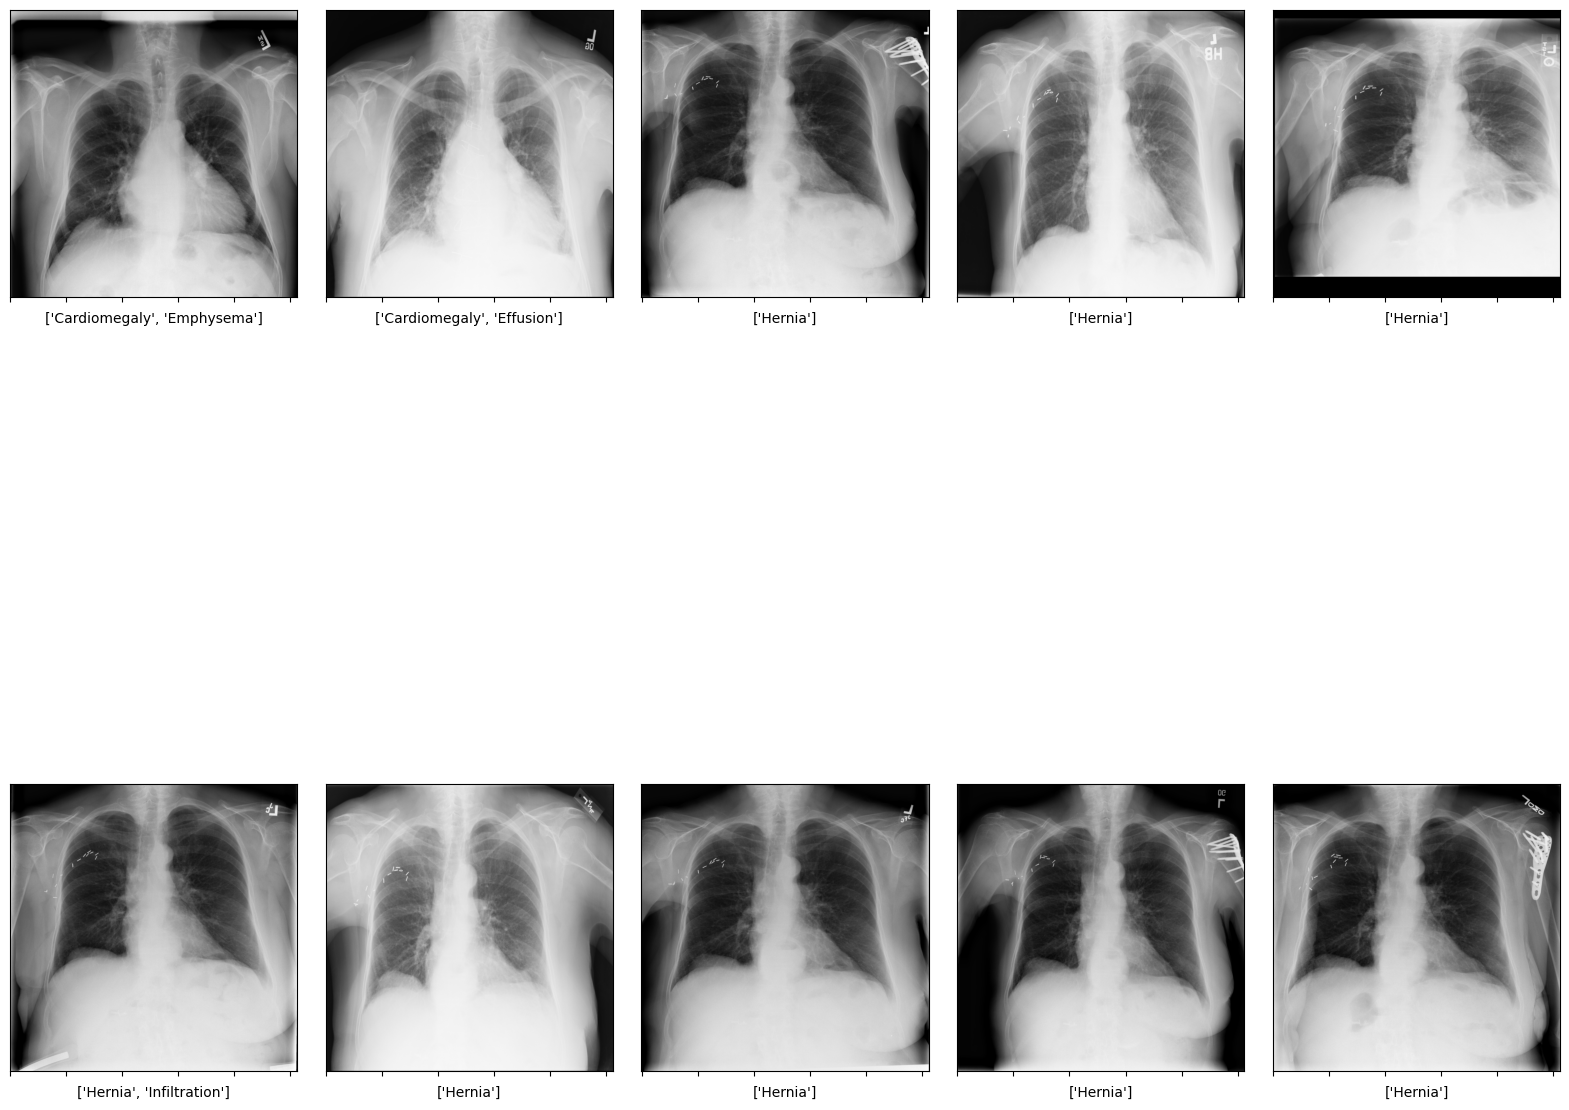

In [ ]:
plot_images(df, 2, 5)


In [ ]:
class CheXNetData(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.df["Image Index"].values[idx]).convert("RGB")
        label = self.df.iloc[:, 2:].values[idx]

        if self.transform:
            image = self.transform(image=np.asarray(image))["image"]

        label = torch.tensor(label, dtype=torch.float)

        return image, label

    def __len__(self):
        # 元のコード（比較用）
        # return len(df)
        # 修正：インスタンスが保持するDataFrameの長さを返す
        return len(self.df)


In [ ]:
transforms = A.Compose(transforms=[A.Normalize(), ToTensorV2()])


In [ ]:
ds = CheXNetData(df=df, transform=transforms)


In [ ]:
image, label = ds[0]


In [ ]:
print(ds[0])


(tensor([[[ 1.3413,  1.2899,  1.2214,  ..., -2.0323, -2.0837, -2.1179],
         [ 1.2899,  1.2385,  1.2214,  ..., -2.0323, -2.0837, -2.1179],
         [ 1.2385,  1.2043,  1.1872,  ..., -2.0323, -2.0837, -2.1179],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ..., -2.1179, -2.1179, -2.1179],
         [ 2.2489,  2.2489,  2.2318,  ..., -2.1179, -2.1179, -2.1179],
         [ 2.2489,  2.2489,  2.2489,  ..., -2.1179, -2.1179, -2.1179]],

        [[ 1.5007,  1.4482,  1.3782,  ..., -1.9482, -2.0007, -2.0357],
         [ 1.4482,  1.3957,  1.3782,  ..., -1.9482, -2.0007, -2.0357],
         [ 1.3957,  1.3606,  1.3431,  ..., -1.9482, -2.0007, -2.0357],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ..., -2.0357, -2.0357, -2.0357],
         [ 2.4286,  2.4286,  2.4111,  ..., -2.0357, -2.0357, -2.0357],
         [ 2.4286,  2.4286,  2.4286,  ..., -2.0357, -2.0357, -2.0357]],

        [[ 1.7163,  1.6640,  1.5942,  ..., -1.7173, -1.7696, -1.8044],
         [ 1.6640,  1.6117,  1.5942,  ..., -

In [ ]:
total = len(ds)
train_len = int(0.8 * total)
val_len = total - train_len

# 元のコード（比較用）
# train_ds, test_ds = random_split(dataset=ds, lengths=[train_len, val_len])
# 修正：Generator を指定して分割を再現可能に
train_ds, test_ds = random_split(
    dataset=ds, lengths=[train_len, val_len], generator=TORCH_GENERATOR
)


In [ ]:
total = len(train_ds)
train_len = int(0.8 * total)
val_len = total - train_len

# 元のコード（比較用）
# train_ds, val_ds = random_split(dataset=train_ds, lengths=[train_len, val_len])
# 修正：こちらも Generator を指定
train_ds, val_ds = random_split(
    dataset=train_ds, lengths=[train_len, val_len], generator=TORCH_GENERATOR
)


In [ ]:
print(
    f"The lengths of train, val and test dataset: {len(train_ds)} images, {len(val_ds)} images, and {len(test_ds)} images"
)


The lengths of train, val and test dataset: 33125 images, 8282 images, and 10352 images


In [ ]:
ds_size = {
    "train": len(train_ds),
    "val": len(val_ds),
    "test": len(test_ds),
}  # Size dictionary


In [ ]:
ds_size


{'train': 33125, 'val': 8282, 'test': 10352}

In [ ]:
# 元のコード（比較用）
# loaders = {
#     "train": DataLoader(train_ds, batch_size=8, shuffle=True),
#     "val": DataLoader(val_ds, batch_size=4),
#     "test": DataLoader(test_ds, batch_size=4),
# }

# 修正：Generator を渡し、worker_init_fn で worker 側の乱数も固定
loaders = {
    "train": DataLoader(
        train_ds,
        batch_size=8,
        shuffle=True,
        generator=TORCH_GENERATOR,
        worker_init_fn=seed_worker,
    ),
    "val": DataLoader(
        val_ds,
        batch_size=4,
        shuffle=False,
        generator=TORCH_GENERATOR,
        worker_init_fn=seed_worker,
    ),
    "test": DataLoader(
        test_ds,
        batch_size=4,
        shuffle=False,
        generator=TORCH_GENERATOR,
        worker_init_fn=seed_worker,
    ),
}


In [ ]:
loaders


{'train': <torch.utils.data.dataloader.DataLoader at 0x148640786cf0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1486408bd7f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1486407a4200>}

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self, n_classes):
        super(DenseNet121, self).__init__()

        # 元のコード（比較用）
        # self.densenet121 = densenet121(pretrained=True)
        # 修正：weights引数を使用
        from torchvision.models import DenseNet121_Weights

        self.densenet121 = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        n_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(n_features, n_classes), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


In [ ]:
ds_batches = {k: len(v) for k, v in loaders.items()}
ds_batches


{'train': 4141, 'val': 2071, 'test': 2588}

In [ ]:
# check is models folder exists
Path("models").mkdir(exist_ok=True)

# Set up logger
logging.basicConfig(
    filename="train.log",
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.INFO,
    filemode="w",
)


In [ ]:
# 元のコード（比較用）
# def calc_mean_auc(labels: torch.tensor, preds: torch.tensor):
#     labels = labels.cpu().detach().numpy()
#     preds = preds.cpu().detach().numpy()
#
#     per_class_AUROC = []
#     for i, name in enumerate(CFG.CLASS_NAMES):
#         try:
#             per_class_AUROC.append(roc_auc_score(labels[:, i], preds[:, i]))
#         except ValueError:
#             pass
#     mean_roc_auc = np.array(per_class_AUROC).mean()
#
#     return mean_roc_auc

# 修正：単一クラス（全て0または全て1）の場合はスキップ
from sklearn.utils.multiclass import unique_labels


def calc_mean_auc(labels: torch.tensor, preds: torch.tensor):
    labels = labels.cpu().detach().numpy()
    preds = preds.cpu().detach().numpy()

    per_class_AUROC = []
    for i, name in enumerate(CFG.CLASS_NAMES):
        y_true = labels[:, i]
        y_score = preds[:, i]
        # y_trueに0/1の両方が含まれていなければAUCは未定義
        if len(np.unique(y_true)) < 2:
            continue
        per_class_AUROC.append(roc_auc_score(y_true, y_score))

    # 有効クラスが無ければNaNを返す
    if len(per_class_AUROC) == 0:
        return float("nan")

    mean_roc_auc = np.array(per_class_AUROC).mean()
    return mean_roc_auc


In [ ]:
best_AUROC = 0.0  # Global AUROC


def run_one_epoch(
    epoch: int,
    ds_sizes: Dict[str, int],
    dataloaders: Dict[str, DataLoader],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss: nn.Module,
    scheduler: torch.optim.lr_scheduler,
):
    """
    Run one complete train-val loop

    Parameter
    ---------

    ds_sizes: Dictionary containing dataset sizes
    dataloaders: Dictionary containing dataloaders
    model: The model
    optimizer: The optimizer
    loss: The loss

    Returns
    -------

    metrics: Dictionary containing metrics

    """
    global best_AUROC

    metrics = {}
    AUROCs = []

    for phase in ["train", "val"]:
        logging.info(f"{phase.upper()} phase")

        if phase == "train":
            model.train()
        else:
            model.eval()

        avg_loss = 0
        running_corrects = 0

        for batch_idx, (images, labels) in enumerate(
            tqdm(dataloaders[phase], total=len(dataloaders[phase]))
        ):

            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)

            # Zero the gradients
            optimizer.zero_grad()

            # Track history if in phase == "train"
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(images)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

                # Calculate AUROC
                auroc = calc_mean_auc(labels, outputs)
                AUROCs.append(auroc)

            avg_loss += loss.item() * images.size(0)

            if batch_idx % CFG.INTERVAL == 0:
                logging.info(
                    f"Epoch {epoch} - {phase.upper()} - Batch {batch_idx} - Loss = {round(loss.item(), 3)} | AUROC = {round(auroc, 3)}"
                )

        epoch_loss = avg_loss / ds_sizes[phase]
        epoch_val_mean = np.array(AUROCs).mean()

        # step the scheduler
        if phase == "train":
            scheduler.step(epoch_loss)

        # save best model wts
        if phase == "val" and epoch_val_mean > best_AUROC:
            best_AUROC = epoch_val_mean
            best_model_wts = deepcopy(model.state_dict())
            # 単一のベストモデルのみ保持（固定パスに上書き）
            Path(CFG.BEST_MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(
                {
                    "epoch": epoch,
                    "val_loss": epoch_loss,
                    "val_AUROC": epoch_val_mean,
                    "model": best_model_wts,
                },
                CFG.BEST_MODEL_PATH,
            )

        # Metrics tracking
        if phase == "train":
            metrics["train_loss"] = round(epoch_loss, 3)
        else:
            metrics["val_loss"] = round(epoch_loss, 3)
            metrics["val_mean_AUROC"] = round(epoch_val_mean, 3)

    return metrics


In [ ]:
def train(dataloaders, ds_sizes, model, optimizer, criterion, scheduler):
    table = PrettyTable(
        field_names=["Epoch", "Train Loss", "Val Loss", "Val Mean AUROC"]
    )

    for epoch in range(CFG.EPOCHS):

        start = time.time()

        metrics = run_one_epoch(
            epoch=epoch,
            ds_sizes=ds_sizes,
            dataloaders=dataloaders,
            model=model,
            optimizer=optimizer,
            loss=criterion,
            scheduler=scheduler,
        )

        end = time.time() - start

        print(f"Epoch completed in: {round(end/60, 3)} mins")

        table.add_row(
            row=[
                epoch + 1,
                metrics["train_loss"],
                metrics["val_loss"],
                metrics["val_mean_AUROC"],
            ]
        )
        print(table)

    # Write results to file
    with open("results.txt", "w") as f:
        results = table.get_string()
        f.write(results)


In [ ]:
model = DenseNet121(n_classes=14).to(CFG.DEVICE)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, mode="min", patience=1
)


In [ ]:
train(
    dataloaders=loaders,
    ds_sizes=ds_size,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
)


100%|██████████| 2071/2071 [06:27<00:00,  5.35it/s]


Epoch completed in: 42.724 mins
+-------+------------+----------+----------------+
| Epoch | Train Loss | Val Loss | Val Mean AUROC |
+-------+------------+----------+----------------+
|   1   |   0.305    |  0.308   |     0.558      |
+-------+------------+----------+----------------+


  0%|          | 19/4141 [00:10<39:39,  1.73it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss

# 保存したモデルをロードしてテストセットで評価
saved_model_path = CFG.BEST_MODEL_PATH

model_loaded = DenseNet121(n_classes=len(CFG.CLASS_NAMES)).to(CFG.DEVICE)
# 元のコード（比較用）
# state_dict = torch.load(saved_model_path, map_location=CFG.DEVICE)
# model_loaded.load_state_dict(state_dict)

# 修正: PyTorch 2.6以降の安全ロードに対応（trusted checkpoint）
checkpoint = torch.load(saved_model_path, map_location=CFG.DEVICE, weights_only=False)
# 互換処理: 'model'キーにstate_dictがある形式と、state_dictのみの両方に対応
state_dict = (
    checkpoint["model"]
    if isinstance(checkpoint, dict) and "model" in checkpoint
    else checkpoint
)
model_loaded.load_state_dict(state_dict)
model_loaded.eval()

out_gt_test_loaded = torch.FloatTensor()
out_pred_test_loaded = torch.FloatTensor()
with torch.no_grad():
    for images, labels in tqdm(loaders["test"]):
        images = images.to(CFG.DEVICE)
        labels = labels.to(CFG.DEVICE)
        outputs = model_loaded(images)
        outputs = outputs.cpu().detach()
        out_gt_test_loaded = torch.cat((out_gt_test_loaded, labels.cpu().detach()), 0)
        out_pred_test_loaded = torch.cat((out_pred_test_loaded, outputs.data), 0)

labels_test_loaded = out_gt_test_loaded.numpy()
preds_test_loaded = out_pred_test_loaded.numpy()

# しきい値で2値化（マルチラベル）
preds_bin = (preds_test_loaded >= 0.5).astype(int)

# 指標の算出
subset_acc = accuracy_score(labels_test_loaded, preds_bin)
micro_f1 = f1_score(labels_test_loaded, preds_bin, average="micro", zero_division=0)
macro_f1 = f1_score(labels_test_loaded, preds_bin, average="macro", zero_division=0)
hamming = hamming_loss(labels_test_loaded, preds_bin)

# AUROCは有効クラスのみで算出（単一クラスはcalc_mean_auc内でスキップ）
mean_auroc = calc_mean_auc(
    torch.tensor(labels_test_loaded), torch.tensor(preds_test_loaded)
)

print(f"Subset accuracy: {subset_acc:.3f}")
print(f"Micro F1: {micro_f1:.3f}")
print(f"Macro F1: {macro_f1:.3f}")
print(f"Hamming loss: {hamming:.3f}")
print(f"Mean AUROC (valid classes only): {mean_auroc}")


100%|██████████| 2588/2588 [08:07<00:00,  5.31it/s]


Subset accuracy: 0.000
Micro F1: 0.000
Macro F1: 0.000
Hamming loss: 0.112
Mean AUROC (valid classes only): 0.5622045814314338


In [ ]:
all_images_train = []  # 入力画像を保存するリスト
with torch.no_grad():
    # model.eval()
    model_loaded.eval()
    out_gt_train = torch.FloatTensor()
    out_pred_train = torch.FloatTensor()
    for images, labels in tqdm(loaders["train"]):
        all_images_train.append(images)
        images_train = images.to(CFG.DEVICE)
        labels_train = labels.to(CFG.DEVICE)

        # outputs = model(images_train)
        outputs = model_loaded(images_train)
        outputs = outputs.cpu().detach()

        out_gt_train = torch.cat((out_gt_train, labels_train.cpu().detach()), 0)
        out_pred_train = torch.cat((out_pred_train, outputs.data), 0)


In [ ]:
all_images_test = []  # 入力画像を保存するリスト
with torch.no_grad():
    # model.eval()
    model_loaded.eval()
    out_gt_test = torch.FloatTensor()
    out_pred_test = torch.FloatTensor()
    for images, labels in tqdm(loaders["test"]):
        all_images_test.append(images)
        images_test = images.to(CFG.DEVICE)
        labels_test = labels.to(CFG.DEVICE)

        # outputs = model(images_test)
        outputs = model_loaded(images_test)
        outputs = outputs.cpu().detach()

        out_gt_test = torch.cat((out_gt_test, labels_test.cpu().detach()), 0)
        out_pred_test = torch.cat((out_pred_test, outputs.data), 0)


In [ ]:
all_images_train_tensor = torch.cat(all_images_train, dim=0)
print("All images train shape:", all_images_train_tensor.shape)
all_images_test_tensor = torch.cat(all_images_test, dim=0)
print("All images test shape:", all_images_test_tensor.shape)


In [ ]:
N_train = all_images_train_tensor.shape[0]
N_test = all_images_test_tensor.shape[0]
C, H, W = all_images_train_tensor.shape[1:]
X_train = all_images_train_tensor.reshape(N_train, C * H * W)
X_test = all_images_test_tensor.reshape(N_test, C * H * W)


In [ ]:
print(X_train.shape)
print(X_test.shape)


In [ ]:
labels_train = out_gt_train.numpy()
preds_train = out_pred_train.numpy()
labels_test = out_gt_test.numpy()
preds_test = out_pred_test.numpy()

per_class_AUROC = []

print("-----PER - CLASS AUROC------")

# 元のコード（比較用）
# for i, name in enumerate(CFG.CLASS_NAMES):
#     try:
#         print(
#             f"{name} - {round(roc_auc_score(labels_test[:, i], preds_test[:, i]), 3)}"
#         )
#     except ValueError:
#         pass
# mean_roc_auc = np.array(per_class_AUROC).mean()

# 修正：単一クラス（全て0 or 全て1）はスキップして明示的に表示
for i, name in enumerate(CFG.CLASS_NAMES):
    y_true = labels_test[:, i]
    y_score = preds_test[:, i]
    if len(np.unique(y_true)) < 2:
        print(f"{name} - skipped (only one class in y_true)")
        continue
    print(f"{name} - {round(roc_auc_score(y_true, y_score), 3)}")


In [ ]:
import time

import cupy as cp
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [ ]:
y_hat_train = preds_train
y_hat_test = preds_test


In [ ]:
print(y_hat_train.shape)
print(y_hat_test.shape)


In [ ]:
# 標準化のためのスケーラーを作成
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# 元のコード（比較用）
# X_test_scaled = scaler.fit_transform(X_test)
# 修正：テストは学習スケーラーで変換のみ
X_test_scaled = scaler.transform(X_test)


In [ ]:
import sys

if "/home/kosukeyano/workspace/huber_aime" not in sys.path:
    sys.path.append("/home/kosukeyano/workspace/huber_aime")

from aime_xai.core import AIME
from aime_xai.core_gpu import AIMEEx

aime = AIME()
aime_np_pinv = AIMEEx(method="numpy_pinv")
aime_np_solve = AIMEEx(method="numpy_solve")
aime_torch_pinv = AIMEEx(method="torch_pinv", device="cuda")
aime_torch_solve = AIMEEx(method="torch_solve", device="cuda")
aime_torch_pinv_batch = AIMEEx(method="torch_pinv_batch", device="cuda", batch_size=10)
aime_torch_solve_batch = AIMEEx(
    method="torch_solve_batch", device="cuda", batch_size=10
)
aime_cupy_pinv = AIMEEx(method="cupy_pinv", device="cuda")
aime_cupy_solve = AIMEEx(method="cupy_solve", device="cuda")
aime_cpn_solve = AIMEEx(method="cupynumeric_solve", device="cuda")


In [ ]:
aime.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_np_pinv.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_np_solve.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_torch_pinv.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_torch_solve.create_explainer(X_train_scaled, y_hat_train, normalize=False)
# aime_torch_pinv_batch.create_explainer(X_train_scaled, y_hat_train, normalize=False)
# aime_torch_solve_batch.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_cupy_pinv.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_cupy_solve.create_explainer(X_train_scaled, y_hat_train, normalize=False)
aime_cpn_solve.create_explainer(X_train_scaled, y_hat_train, normalize=False)


In [ ]:
feature_names = [f"pixel_{i}" for i in range(X_train.shape[1])]
class_names = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia",
]


In [ ]:
# グローバル特徴重要度の計算と可視化
df_global_importance = aime.global_feature_importance(
    feature_names=feature_names, class_names=class_names, top_k=10
)


In [ ]:
# グローバル特徴重要度の計算と可視化
df_global_importance = aime_cupy_pinv.global_feature_importance(
    feature_names=feature_names, class_names=class_names, top_k=10
)


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def compute_signed_2d(img3, mode="maxabs", clip_pct=99.5):
    """
    img3: (H,W,3) の寄与マップ (局所/大域 いずれも可)
    mode: "l2" | "maxabs"
        - "l2"    : 符号=優勢チャネルの符号、値=L2ノルム
        - "maxabs": 符号=優勢チャネルの符号、値=max(|R|,|G|,|B|)
    clip_pct: 上位パーセンタイルで外れ値をクリップして[-1,1]に正規化
    return: [-1,1] 正規化の 2D マップ
    """
    C = img3.astype(np.float32)
    absC = np.abs(C)
    dom_idx = np.argmax(absC, axis=2)

    if mode == "l2":
        mag = np.sqrt((C**2).sum(axis=2))
    elif mode == "maxabs":
        mag = absC.max(axis=2)
    else:
        raise ValueError("mode must be 'l2' or 'maxabs'")

    sign = np.take_along_axis(np.sign(C), dom_idx[..., None], axis=2).squeeze(2)
    signed = sign * mag

    vmax = np.percentile(np.abs(signed), clip_pct) + 1e-12
    signed = np.clip(signed, -vmax, vmax) / vmax
    return signed


def show_global_signed(w_c3, title, fname=None, mode="maxabs"):
    signed2d = compute_signed_2d(w_c3, mode=mode)
    plt.figure(figsize=(4, 4))
    plt.imshow(
        signed2d, cmap="inferno", norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    )
    plt.title(title)
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()


def show_local_with_original(
    orig_img3, contrib_img3, true_name, fname=None, mode="maxabs"
):
    signed2d = compute_signed_2d(contrib_img3, mode=mode)
    fig, axes = plt.subplots(
        1,
        3,
        figsize=(9, 4),
        gridspec_kw={"width_ratios": [1, 1, 0.05]},
    )
    ax0, ax1, cax = axes
    ax0.imshow(orig_img3)
    ax0.set_title(f"Original (true={true_name})")
    ax0.axis("off")
    im = ax1.imshow(
        signed2d, cmap="inferno", norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    )
    ax1.set_title(f"Local Importance ({mode}, signed)")
    ax1.axis("off")
    fig.colorbar(im, cax=cax)
    plt.subplots_adjust(wspace=0.02)
    if fname:
        plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()


In [ ]:
# グローバルな特徴重要度のデータフレームを取得（RGB対応）
df_global = aime.global_feature_importance_without_viz(
    feature_names=feature_names, class_names=class_names
)
# DataFrameを取得
df_global = df_global.to_pandas() if hasattr(df_global, "to_pandas") else df_global

# 可視化設定
rows, cols = 2, 7
fig, axes = plt.subplots(rows, cols, figsize=(25, 10))

# 各クラスごとに (H,W,3) へ整形し、RGB集約（符号付き）で表示
for idx, class_label in enumerate(class_names):
    w_c = df_global.loc[class_label].values  # 長さ = 3*H*W
    H = W = 1024
    w_c3 = w_c.reshape(3, H, W).transpose(1, 2, 0)  # (H,W,3)

    ax = axes[idx // cols, idx % cols]
    signed2d = compute_signed_2d(w_c3, mode="maxabs")
    im = ax.imshow(
        signed2d,
        cmap="inferno",
        norm=mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1),
    )
    ax.set_title(f"{class_label}")
    ax.axis("off")

fig.tight_layout()
# 代表imからカラーバーを作成
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
cbar.set_label("Signed Feature Importance (RGB aggregated)")
plt.show()


In [ ]:
# ローカル特徴重要度の計算と可視化
index = 1
# サンプルのインデックス
x_sample = X_train_scaled[index]
y_sample = y_hat_train[index]
original_label = labels_train[index]

# ローカル特徴重要度の計算
df_local_importance = aime.local_feature_importance_without_viz(
    x_sample,
    y_sample,
    feature_names=feature_names,
    scale=True,
    scaler=scaler,
    ignore_zero_features=True,
)

# ローカル重要度（RGB対応）
H = W = 1024
# 局所寄与ベクトル (3*H*W) を (H,W,3) に整形
importance_local = df_local_importance.values.reshape(3, H, W).transpose(1, 2, 0)

original_class_index = original_label.argmax()  # 配列内で1の位置を取得
original_class = class_names[original_class_index]

# 元画像（学習時の正規化を逆変換して0-1へ）
orig = all_images_train_tensor[index].cpu().numpy().transpose(1, 2, 0)
imagenet_mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
orig_img3 = np.clip(orig * imagenet_std + imagenet_mean, 0, 1)

# 可視化（符号付きRGB集約）
show_local_with_original(
    orig_img3=orig_img3,
    contrib_img3=importance_local,
    true_name=original_class,
    fname=None,
    mode="maxabs",
)
